In [ ]:
!pip install transformers spacy
! python -m spacy download en_core_web_trf
!apt install subversion
!mkdir data
!svn checkout https://github.com/ChanCheeKean/datasets/trunk/nlp data

In [ ]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import spacy, nltk, re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from pickle import dump, load
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.layers import Dropout, Dense, Input, Activation, LSTM, Embedding, TimeDistributed, MaxPooling1D
from tensorflow.keras.models import Model, Sequential, load_model

# 1) LSTM NER

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.TPUStrategy(resolver)

## 1.1 Data loading

In [ ]:
data = pd.read_csv("data/ner_dataset.csv", encoding = "ISO-8859-1")
print(data['Sentence #'].unique())
data.head()

['Sentence: 1' nan 'Sentence: 2' ... 'Sentence: 47957' 'Sentence: 47958'
 'Sentence: 47959']


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [ ]:
with open('data/large/words.txt') as f:
    vocab = [sent for sent in f.read().splitlines()]

with open('data/large/tags.txt') as f:
    tag = [sent for sent in f.read().splitlines()]

with open('data/large/train/sentences.txt') as f:
    train_x = [sent for sent in f.read().splitlines()]

with open('data/large/train/labels.txt') as f:
    train_y = [sent for sent in f.read().splitlines()]

with open('data/large/val/sentences.txt') as f:
    val_x = [sent for sent in f.read().splitlines()]

with open('data/large/val/labels.txt') as f:
    val_y = [sent for sent in f.read().splitlines()]

with open('data/large/test/sentences.txt') as f:
    test_x = [sent for sent in f.read().splitlines()]

with open('data/large/test/labels.txt') as f:
    test_y = [sent for sent in f.read().splitlines()]

In [ ]:
print(len(vocab))
print(vocab[100])
print(tag)

# check train count
print(len(train_x))
print(len(train_y))
print(train_x[100])
print(train_y[100])

35180
Energy
['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim', 'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve', 'I-eve', 'I-nat']
33570
33570
The Pakistani military launched its offensive in Orakzai to hunt Taliban insurgents .
O B-gpe O O O O O B-geo O O B-org O O


In [ ]:
# tokenized and one hot with keras text
tokenizer_x = text.Tokenizer(oov_token='UNK')
tokenizer_x.fit_on_texts(vocab)
tokenizer_y = text.Tokenizer(lower=False, filters=[])
tokenizer_y.fit_on_texts(tag)

print("Original Text:")
print(train_x[0])
print(train_y[0])

# label encoder
train_x_token = tokenizer_x.texts_to_sequences(train_x)
train_y_token = tokenizer_y.texts_to_sequences(train_y)
val_x_token = tokenizer_x.texts_to_sequences(val_x)
val_y_token = tokenizer_y.texts_to_sequences(val_y)
test_x_token = tokenizer_x.texts_to_sequences(test_x)
test_y_token = tokenizer_y.texts_to_sequences(test_y)

print("\nAfter Label Encoder:")
print(train_x_token[0])
print(train_y_token[0])

# padding
train_x_token = sequence.pad_sequences(train_x_token, padding='post', truncating='post', maxlen=30)
val_x_token = sequence.pad_sequences(val_x_token, padding='post', truncating='post', maxlen=30)
test_x_token = sequence.pad_sequences(test_x_token, padding='post', truncating='post', maxlen=30)
train_y_token = sequence.pad_sequences(train_y_token, padding='post', truncating='post', maxlen=30)
val_y_token = sequence.pad_sequences(val_y_token, padding='post', truncating='post', maxlen=30)
test_y_token = sequence.pad_sequences(test_y_token, padding='post', truncating='post', maxlen=30)

print("\nAfter Padding:")
print(train_x_token[0])
print(train_y_token[0])

# one hot of y --> sparse
train_y_token = tf.one_hot(train_y_token, len(tokenizer_y.index_word))
val_y_token = tf.one_hot(val_y_token, len(tokenizer_y.index_word))
test_y_token = tf.one_hot(test_y_token, len(tokenizer_y.index_word))

print("\nAfter Onehot Encoder:")
print(train_x_token[0])
print(train_y_token[0])
print(train_x_token.shape)
print(train_y_token.shape)

print("\nTokenizer Index:")
print(tokenizer_x.index_word[182])
print(tokenizer_x.index_word[1])

Original Text:
Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O

After Label Encoder:
[1493, 95, 1494, 815, 4765, 816, 1495, 31, 1496, 181, 96, 47, 249, 48, 1497, 181, 4766, 95, 298, 1498, 1499, 1500, 182]
[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1]

After Padding:
[1493   95 1494  815 4765  816 1495   31 1496  181   96   47  249   48
 1497  181 4766   95  298 1498 1499 1500  182    0    0    0    0    0
    0    0]
[1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 3 1 1 1 1 1 0 0 0 0 0 0]

After Onehot Encoder:
[1493   95 1494  815 4765  816 1495   31 1496  181   96   47  249   48
 1497  181 4766   95  298 1498 1499 1500  182    0    0    0    0    0
    0    0]
tf.Tensor(
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

The tag_map corresponds to one of the possible tags a word can have. Run the cell below to see the possible classes you will be predicting. The prepositions in the tags mean:
* I: Token is inside an entity.
* B: Token begins an entity.

So the coding scheme that tags the entities is a minimal one where B- indicates the first token in a multi-token entity, and I- indicates one in the middle of a multi-token entity. If you had the sentence

**"Sharon flew to Miami on Friday"**

the outputs would look like:

```
Sharon B-per
flew   O
to     O
Miami  B-geo
on     O
Friday B-tim
```

your tags would reflect three tokens beginning with B-, since there are no multi-token entities in the sequence. But if you added Sharon's last name to the sentence:

**"Sharon Floyd flew to Miami on Friday"**

```
Sharon B-per
Floyd  I-per
flew   O
to     O
Miami  B-geo
on     O
Friday B-tim
```

then your tags would change to show first "Sharon" as B-per, and "Floyd" as I-per, where I- indicates an inner token in a multi-token sequence.

## 1.2 Model Building

In [ ]:
def lstm_model(n_x, n_y, n_h, vocab_size, emb_dim):
    i = Input(shape=(n_x, )) # (m, n_x)
    x = Embedding(vocab_size + 1, emb_dim)(i) # (m, vocab_len, emb_dim)
    x = LSTM(n_h, return_sequences=True)(x) # (m, vocab_len, n_h)
    x = Dropout(0.5)(x) # (m, vocab_len, n_h)
    x = LSTM(n_h, return_sequences=True)(x) # (m, vocab_len, n_h)
    x = TimeDistributed(Dense(n_y, activation='softmax'))(x) # (m, vocab_len, n_y)
    model = Model(i, x)
    return model

tf.keras.backend.clear_session()

In [ ]:
with strategy.scope():
  model = lstm_model(train_x_token.shape[1], tokenizer_y.document_count, 128, tokenizer_x.document_count, 50)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 50)            1759050   
_________________________________________________________________
lstm (LSTM)                  (None, 30, 128)           91648     
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 17)            2193      
Total params: 1,984,475
Trainable params: 1,984,475
Non-trainable params: 0
___________________________________________________

In [ ]:
r = model.fit(train_x_token, train_y_token, batch_size=64, epochs=5, validation_data=(val_x_token, val_y_token))

Epoch 1/5
525/525 [==============================] - 13s 24ms/step - loss: 0.2110 - accuracy: 0.9332 - val_loss: 0.2872 - val_accuracy: 0.9133
Epoch 2/5
525/525 [==============================] - 12s 24ms/step - loss: 0.2006 - accuracy: 0.9364 - val_loss: 0.2904 - val_accuracy: 0.9147
Epoch 3/5
525/525 [==============================] - 12s 24ms/step - loss: 0.1900 - accuracy: 0.9397 - val_loss: 0.2897 - val_accuracy: 0.9137
Epoch 4/5
525/525 [==============================] - 12s 23ms/step - loss: 0.1810 - accuracy: 0.9426 - val_loss: 0.3021 - val_accuracy: 0.9145
Epoch 5/5
525/525 [==============================] - 12s 24ms/step - loss: 0.1735 - accuracy: 0.9448 - val_loss: 0.3066 - val_accuracy: 0.9144


<function matplotlib.pyplot.show>

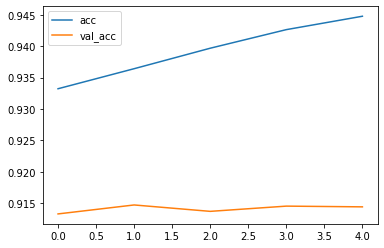

In [ ]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show

## 1.3 Evaluation

In [ ]:
loss, acc = model.evaluate(test_x_token, test_y_token, batch_size=128)
print(acc)

57/57 [==============================] - 2s 19ms/step - loss: 0.3009 - accuracy: 0.9154
0.9153785109519958


In [ ]:
def predict(sentence, model):
    tokenized_sent = tokenizer_x.texts_to_sequences(sentence)
    tokenized_sent = sequence.pad_sequences(tokenized_sent, padding='post', truncating='post', maxlen=30)
    pred = model.predict(tokenized_sent)
    pred = np.argmax(pred, axis=-1)
    pred_lis = []
    for out in pred:
        pred = [tokenizer_y.index_word.get(x) for x in out]
        pred_lis.append(pred)
    return pred_lis

In [ ]:
# New york times news:
sentence = ["Peter Navarro, the White House director of trade and manufacturing policy of U.S, \
said in an interview on Sunday morning that the White House was working to prepare for \
the possibility of a second wave of the coronavirus in the fall, though he said it wouldn’t necessarily come"]

predictions = predict(sentence, model)

In [ ]:
for x, y in zip(sentence[0].split(' '), predictions[0]):
    if y != 'O':
        print(x, y)

Peter B-per
Navarro, I-per
White B-org
House I-org
director I-org
said B-geo
morning B-tim
that I-tim
House B-org
was I-org


# 2) NER (Transformer)

[Named Entity Recognition with BERT in PyTorch](https://towardsdatascience.com/named-entity-recognition-with-bert-in-pytorch-a454405e0b6a)

In [ ]:
from transformers import BertTokenizerFast
from transformers import BertForTokenClassification
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm

In [ ]:
with open('data/large/train/sentences.txt') as f:
    train_x = [sent for sent in f.read().splitlines()]

with open('data/large/train/labels.txt') as f:
    train_y = [sent for sent in f.read().splitlines()]

with open('data/large/val/sentences.txt') as f:
    val_x = [sent for sent in f.read().splitlines()]

with open('data/large/val/labels.txt') as f:
    val_y = [sent for sent in f.read().splitlines()]

# check train count
print(len(train_x))
print(len(train_y))
print(train_x[100])
print(train_y[100])

train_y = [i.split() for i in train_y]
val_y = [i.split() for i in val_y]

# Check how many labels are there in the dataset
unique_labels = set()

for lb in train_y:
     [unique_labels.add(i) for i in lb if i not in unique_labels]
print(unique_labels)

# Map each label into its id representation and vice versa
labels_to_ids = {k: v for v, k in enumerate(sorted(unique_labels))}
ids_to_labels = {v: k for v, k in enumerate(sorted(unique_labels))}
print(labels_to_ids)

33570
33570
The Pakistani military launched its offensive in Orakzai to hunt Taliban insurgents .
O B-gpe O O O O O B-geo O O B-org O O
{'B-nat', 'I-eve', 'B-tim', 'B-geo', 'I-org', 'O', 'I-gpe', 'I-tim', 'B-org', 'I-art', 'B-gpe', 'B-per', 'B-art', 'I-geo', 'B-eve', 'I-per', 'I-nat'}
{'B-art': 0, 'B-eve': 1, 'B-geo': 2, 'B-gpe': 3, 'B-nat': 4, 'B-org': 5, 'B-per': 6, 'B-tim': 7, 'I-art': 8, 'I-eve': 9, 'I-geo': 10, 'I-gpe': 11, 'I-nat': 12, 'I-org': 13, 'I-per': 14, 'I-tim': 15, 'O': 16}


In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')
text_tokenized = tokenizer(train_x[0], padding='max_length', max_length=64, truncation=True, return_tensors="pt")
print(text_tokenized)

{'input_ids': tensor([[  101, 26159,  1104,  8568,  4487,  5067,  1138,  9639,  1194,  1498,
          1106,  5641,  1103,  1594,  1107,  5008,  1105,  4555,  1103, 10602,
          1104,  1418,  2830,  1121,  1115,  1583,   119,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

**Adjusting Label After Tokenization** is needed because the length of the sequence is no longer matching the length of the original label.

*   The addition of special tokens from BERT such as [CLS], [SEP], and [PAD]
*   The fact that some tokens are splitted into sub-words.

The consequence: sequence length after tokenization != length of the initial label.

In [ ]:
# SEP, CLS, PAD token is none. SPlitted word share same ids
print(text_tokenized.word_ids()[:30])

[None, 0, 1, 2, 2, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, None, None, None]


Either Way:

1.   Only provide a label to the first sub-word of each splitted token. The continuation of the sub-word then will simply have ‘-100’ as a label. All tokens that don’t have word_ids will also be labeled with ‘-100’. Set `label_all_tokens` to False
2.   Provide the same label among all of the sub-words that belong to the same token. All tokens that don’t have word_ids will be labeled with ‘-100’.

In [ ]:
def align_label(texts, labels, tokenized_inputs=None, label_all_tokens=False):
    '''if label_all_tokens=True: Provide the same label among all of the sub-words'''

    if tokenized_inputs is None:
        tokenized_inputs = tokenizer(texts, padding='max_length', max_length=64, truncation=True)
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:

        if word_idx is None:
            label_ids.append(-100)

        elif word_idx != previous_word_idx:
            try:
                label_ids.append(labels_to_ids[labels[word_idx]])
            except:
                label_ids.append(-100)

        # if sub-word
        else:
            try:
                label_ids.append(labels_to_ids[labels[word_idx]] if label_all_tokens else -100)
            except:
                label_ids.append(-100)
        previous_word_idx = word_idx

    return label_ids

print(train_y[100])
new_label = align_label(train_x[100], train_y[100])
print(new_label)

['O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'B-org', 'O', 'O']
[-100, 16, 3, 16, 16, 16, 16, 16, 2, -100, -100, 16, 16, 5, 16, 16, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]


In [ ]:
# torch dataset
class BertDataSet(torch.utils.data.Dataset):

    def __init__(self, txt, lb):
        self.texts = tokenizer(
            txt,
            padding='max_length',
            max_length=64,
            truncation=True,
            return_tensors="pt"
        )
        self.labels = [align_label(i, j) for i, j in zip(txt, lb)]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.texts.items()}
        item['labels'] = torch.LongTensor(self.labels[idx])
        return item

In [ ]:
class BertModel(torch.nn.Module):
    def __init__(self):
        super(BertModel, self).__init__()
        self.bert = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=len(unique_labels))

    def forward(self, input_id, mask, label):
        # it returns both embedding and loss due to BertForTokenClassification
        output = self.bert(input_ids=input_id, attention_mask=mask, labels=label, return_dict=False)
        return output

In [ ]:
train_label = train_y[:8]
train_data = train_x[:8]
train_label = [align_label(i, j) for i, j in zip(train_data, train_label)]
train_data = tokenizer(train_data, padding='max_length', max_length=64, truncation=True, return_tensors="pt")
mask = train_data['attention_mask']
input_id = train_data['input_ids']
test_model = BertModel()
loss, logits = test_model(input_id, mask, torch.tensor(train_label))

print(loss)
print(logits.size())

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['cl

tensor(2.7760, grad_fn=<NllLossBackward0>)
torch.Size([8, 64, 17])


In [ ]:
# the criterion in BertForTokenClassification model
criterion = torch.nn.CrossEntropyLoss(ignore_index=-100)
truth = torch.tensor(train_label)
truth = truth.view(truth.shape[0] * truth.shape[1]).type(torch.LongTensor)
logits = logits.view(-1, logits.shape[2]).type(torch.FloatTensor)
criterion(logits, truth)

tensor(2.7760, grad_fn=<NllLossBackward0>)

In [ ]:
train_dataset = BertDataSet(train_x, train_y)
val_dataset = BertDataSet(val_x, val_y)

train_dataloader = DataLoader(train_dataset, num_workers=4, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, num_workers=4, batch_size=64)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
train_label = torch.randint(0, 17, (32, 64))
logits = torch.randn(32, 64, 17)
mask = (train_label != -100)

filtered_logits = logits[mask]

print(filtered_logits.size())

torch.Size([2048, 17])


In [ ]:
mask.size()

torch.Size([32, 64])

In [ ]:
def train_loop(model, train_x, train_y, val_x, val_y):

    train_dataset = BertDataSet(train_x, train_y,)
    val_dataset = BertDataSet(val_x, val_y)

    train_dataloader = DataLoader(train_dataset, num_workers=2, batch_size=32, shuffle=True)
    val_dataloader = DataLoader(val_dataset, num_workers=2, batch_size=32)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    print(f"Device Used: {device}")

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    if use_cuda:
        model = model.cuda()

    best_acc = 0
    best_loss = 1000

    for epoch_num in range(EPOCHS):

        total_acc_train = 0
        total_loss_train = 0
        model.train()

        for train_data in train_dataloader:
            train_label = train_data['labels'].to(device)
            mask = train_data['attention_mask'].to(device)
            input_id = train_data['input_ids'].to(device)
            optimizer.zero_grad()

            # logits(m, seq_len, num_class)
            loss, logits = model(input_id, mask, train_label)
            # (m * seq_len (non -100), num_class)
            logits_clean = logits[train_label != -100]
            label_clean = train_label[train_label != -100]
            # (m * seq_len (non -100))
            predictions = logits_clean.argmax(dim=1)

            acc = (predictions == label_clean).float().mean()
            total_acc_train += acc
            total_loss_train += loss.item()
            loss.backward()
            optimizer.step()

        model.eval()

        total_acc_val = 0
        total_loss_val = 0

        for val_data in val_dataloader:

            val_label = val_data['labels'].to(device)
            mask = val_data['attention_mask'].to(device)
            input_id = val_data['input_ids'].to(device)
            loss, logits = model(input_id, mask, val_label)

            logits_clean = logits[val_label != -100]
            label_clean = val_label[val_label != -100]
            predictions = logits_clean.argmax(dim=1)

            acc = (predictions == label_clean).float().mean()
            total_acc_val += acc
            total_loss_val += loss.item()

        val_accuracy = total_acc_val / len(val_y)
        val_loss = total_loss_val / len(val_y)

        print(f'Epochs: {epoch_num + 1} | Loss: {total_loss_train / len(train_dataloader): .3f} | Val_Loss: {total_loss_val / len(val_dataloader): .3f} ')
        print(f'Accuracy: {total_acc_train / len(train_dataloader): .3f} | Accuracy: {total_acc_val / len(val_dataloader): .3f}')

LEARNING_RATE = 5e-5
EPOCHS = 5
model = BertModel()
train_loop(model, train_x, train_y, val_x, val_y)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['cl

Device Used: cuda


# 3) NER (Spacy Pipelines)

In [ ]:
def spacy_tokenizer(nlp):
    ## https://spacy.io/usage/linguistic-features#special-cases
    # [$&+,:;=?|'<>.^*()%!-]

    # split special characters away from beginning of text
    prefixes = nlp.Defaults.prefixes + ["^[^\w\s]"]
    prefix_regex = spacy.util.compile_prefix_regex(prefixes)
    nlp.tokenizer.prefix_search = prefix_regex.search

    # split special characters away from the end of text
    suffixes = nlp.Defaults.suffixes + ["[^\w\s]$"]
    suffix_regex = spacy.util.compile_suffix_regex(suffixes)
    nlp.tokenizer.suffix_search = suffix_regex.search

    # split special characters in between text
    infixes = nlp.Defaults.infixes + ["[^\w\s]"]
    infix_regex = spacy.util.compile_infix_regex(infixes)
    nlp.tokenizer.infix_finditer = infix_regex.finditer
    return nlp

import spacy
from spacy.tokens import Doc

pre_roberta_nlp = spacy.load(
    'en_core_web_trf',
    disable=['tagger', 'parser', 'attribute_ruler', 'lemmatizer']
)
pre_roberta_nlp.add_pipe('sentencizer')
sentence = "I like the ice cream from Brunos."

# doc = pre_roberta_nlp(Doc(pre_roberta_nlp.vocab, [sentence]))
doc = pre_roberta_nlp(sentence)
pre_roberta_nlp = spacy_tokenizer(pre_roberta_nlp)

# print location and detected brand
print([(e.text, e.start_char-e.sent.start_char, e.end_char-e.sent.start_char, e.label_) for e in doc.ents], '\n')

for d in doc:
    print(f"{d.text} | {d.ent_iob_} | {d.ent_type_}")

[('Brunos', 26, 32, 'ORG')] 

I | O | 
like | O | 
the | O | 
ice | O | 
cream | O | 
from | O | 
Brunos | B | ORG
. | O | 


# 4) GLiNER

[GLiNER Repo](https://github.com/urchade/GLiNER/tree/main)

In [ ]:
!mkdir data
!wget https://huggingface.co/datasets/Universal-NER/Pile-NER-type/resolve/main/train.json?download=true -O ./data/train.json
!pip install tqdm transformers flair

In [ ]:
import sys
import json
import argparse
import re
import ast
import random
from pathlib import Path
import yaml
from tqdm import tqdm
from collections import defaultdict
from typing import List, Tuple, Dict, Optional, Union
from types import SimpleNamespace
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader
from transformers import get_cosine_schedule_with_warmup
from huggingface_hub import PyTorchModelHubMixin, hf_hub_download
from flair.embeddings import TransformerWordEmbeddings
from flair.data import Sentence

## 4.1 Data Processing

In [ ]:
def load_data(filepath):
    """Loads data from a JSON file."""
    with open(filepath, "r") as f:
        data = json.load(f)
    return data

def tokenize_text(text):
    """Tokenizes the input text into a list of tokens."""
    return re.findall(r"\w+(?:[-_]\w+)*|\S", text)

def extract_entity_spans(entry):
    """Extracts entity spans from an entry."""
    len_start = len("What describes ")
    len_end = len(" in the text?")
    entity_types, entity_texts, negative = [], [], []

    for c in entry["conversations"]:
        if c["from"] == "human" and c["value"].startswith("Text: "):
            text = c["value"][len("Text: ") :]
            tokenized_text = tokenize_text(text)
        elif c["from"] == "human" and c["value"].startswith("What describes "):
            entity_type = c["value"][len_start:-len_end]
            entity_types.append(entity_type)
        elif c["from"] == "gpt" and c["value"].startswith("["):
            if c["value"] == "[]":
                negative.append(entity_types.pop())
                continue
            texts_ents = ast.literal_eval(c["value"])
            entity_texts.extend(texts_ents)
            num_repeat = len(texts_ents) - 1
            entity_types.extend([entity_types[-1]] * num_repeat)

    entity_spans = []
    for j, entity_text in enumerate(entity_texts):
        entity_tokens = tokenize_text(entity_text)
        matches = []

        # shift the inde from start to end, check if the word match
        for i in range(len(tokenized_text) - len(entity_tokens) + 1):
            if (
                " ".join(tokenized_text[i : i + len(entity_tokens)]).lower()
                == " ".join(entity_tokens).lower()
            ):
                matches.append((i, i + len(entity_tokens) - 1, entity_types[j]))
        if matches:
            entity_spans.extend(matches)

    return {"tokenized_text": tokenized_text, "ner": entity_spans, "negative": negative}

def process_data(data):
    """Processes a list of data entries to extract entity spans."""
    all_data = [extract_entity_spans(entry) for entry in tqdm(data)]
    return all_data

def save_data_to_file(data, filepath):
    """Saves the processed data to a JSON file."""
    with open(filepath, "w") as f:
        json.dump(data, f)

In [ ]:
### data processing ###
data = load_data("./data/train.json")
processed_data = process_data(data)
save_data_to_file(processed_data, "./data/pilener_train.json")
print(data[0])

## 4.2 Configuration

In [ ]:
config = SimpleNamespace(
      num_steps=1000,
      train_batch_size=8,
      eval_every=100,
      save_directory="logs",
      warmup_ratio=0.1,
      device="cpu",
      lr_encoder=1e-5,
      lr_others=5e-5,
      freeze_token_rep=False,
      # maximum number of entity types
      max_types=25,
      # shuffle or not entity types
      shuffle_types=True,
      # randomly drop entity types
      random_drop=True,
      # ratio of positive/negative types
      # 1 mean 50%/50%, 2 mean 33%/66%, 3 mean 25%/75% ...
      max_neg_type_ratio=1,
      max_len=384,  # maximum sentence length
      max_width=12, # n-gram
  )

## 4.3 Data Loading

In [ ]:
def get_dict(spans, classes_to_id):
    dict_tag = defaultdict(int)
    for span in spans:
        if span[2] in classes_to_id:
            dict_tag[(span[0], span[1])] = classes_to_id[span[2]]
    return dict_tag

def preprocess_spans(tokens, ner, classes_to_id, config):
    # truncate long sentence
    max_len = config.max_len
    if len(tokens) > max_len:
        length = max_len
        tokens = tokens[:max_len]
    else:
        length = len(tokens)

    # get n-gram span
    spans_idx = []
    for i in range(length):
        spans_idx.extend([(i, i + j) for j in range(config.max_width)])

    # convert ner type to id
    dict_lab = get_dict(ner, classes_to_id) if ner else defaultdict(int)

    # 0 for null labels, -1 for out of span
    span_label = torch.LongTensor([dict_lab[i] for i in spans_idx])
    spans_idx = torch.LongTensor(spans_idx)
    valid_span_mask = spans_idx[:, 1] > length - 1
    span_label = span_label.masked_fill(valid_span_mask, -1)

    return {
        "tokens": tokens, # all tokenized words
        "span_idx": spans_idx, # list of n-gram, len(tokens) * max_width
        "span_label": span_label, # 0 for no label, -1 for out of sentence
        "seq_length": length, # tokens length
        "entities": ner, # golden truth
    }

def get_negatives(batch_list, sampled_neg=5):
    ent_types = []
    for b in batch_list:
        types = set([el[-1] for el in b["ner"]])
        ent_types.extend(list(types))
    ent_types = list(set(ent_types))
    # sample negatives
    random.shuffle(ent_types)
    return ent_types[:sampled_neg]


def collate_fn(batch_list, entity_types=None, config=None):
    # batch_list: list of dict containing tokens, ner

    if entity_types is None:
        # get negative entity types from other row in the batch
        negs = get_negatives(batch_list, 100)

        class_to_ids = []
        id_to_classes = []

        for b in batch_list:
            # negs = b["negative"]
            random.shuffle(negs)
            # negs = negs[:sampled_neg]
            max_neg_type_ratio = int(config.max_neg_type_ratio)

            if max_neg_type_ratio == 0:
                # no negatives
                neg_type_ratio = 0
                negs_i = []
            else:
                neg_type_ratio = random.randint(0, max_neg_type_ratio)
                negs_i = negs[: len(b["ner"]) * neg_type_ratio]

            # this is the list of all possible entity types (positive and negative)
            types = list(set([el[-1] for el in b["ner"]] + negs_i))

            # shuffle (every epoch)
            random.shuffle(types)
            if len(types) != 0:
                # random drop
                if config.random_drop:
                    num_ents = random.randint(1, len(types))
                    types = types[:num_ents]

            # maximum number of entities types
            types = types[: int(config.max_types)]

            # supervised training
            if "label" in b:
                types = sorted(b["label"])

            class_to_id = {k: v for v, k in enumerate(types, start=1)}
            id_to_class = {k: v for v, k in class_to_id.items()}
            class_to_ids.append(class_to_id)
            id_to_classes.append(id_to_class)

        batch = [
            preprocess_spans(b["tokenized_text"], b["ner"], class_to_ids[i], config=config)
            for i, b in enumerate(batch_list)
        ]

    else:
        class_to_ids = {k: v for v, k in enumerate(entity_types, start=1)}
        id_to_classes = {k: v for v, k in class_to_ids.items()}
        batch = [
            preprocess_spans(b["tokenized_text"], b["ner"], class_to_ids, config=config)
            for b in batch_list
        ]

    span_idx = pad_sequence(
        [b["span_idx"] for b in batch], batch_first=True, padding_value=0
    )

    span_label = pad_sequence(
        [el["span_label"] for el in batch], batch_first=True, padding_value=-1
    )

    return {
        "seq_length": torch.LongTensor([el["seq_length"] for el in batch]),
        "span_idx": span_idx,
        "tokens": [el["tokens"] for el in batch],
        "span_mask": span_label != -1,
        "span_label": span_label,
        "entities": [el["entities"] for el in batch],
        "classes_to_id": class_to_ids,
        "id_to_classes": id_to_classes,
    }


def create_dataloader(data, entity_types=None, config=None, **kwargs):
    return DataLoader(
        data, collate_fn=lambda x: collate_fn(x, entity_types, config=config), **kwargs
    )

In [ ]:
train_path = "./data/pilener_train.json"
with open(train_path, "r") as f:
    train_data = json.load(f)
train_dataloader = create_dataloader(
    train_data, batch_size=config.train_batch_size, config=config, shuffle=True
)

print(next(iter(train_dataloader)))